In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.models import load_model

Using TensorFlow backend.


# COLLECTING DATA

In [2]:
df = pd.read_csv("train.csv")

In [37]:
df = df.drop(['India','Australia','China'], axis =1)

In [3]:
train  = df[df['date']<='2012-03-30']

In [4]:
test  = df[df['date']>'2012-03-30']

In [5]:
train = train.drop('date',axis=1)


In [6]:
validation =test.drop('date', axis =1)

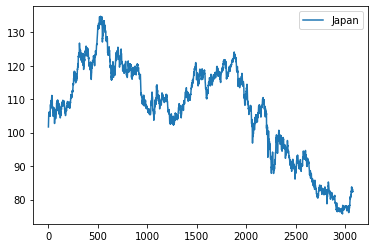

In [7]:
train.plot()

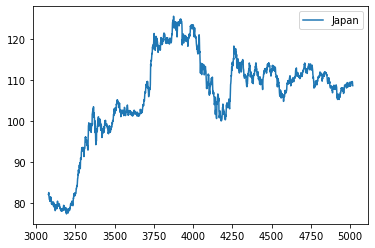

In [8]:
validation.plot()

In [9]:
#parameters for LSTM model
batch_size = 43
epochs = 90
timesteps = 10

In [10]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print(x)
    return (max(train_length_values))

In [11]:
length = get_train_length(train, batch_size, 0.1)
print(length)

2709
2752
2752


In [12]:
upper_train = length + timesteps*2
df_train1 = train[0:upper_train]
train1 = df_train1.values
train.shape

(3079, 1)

In [13]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit(np.float64(train1)).transform(np.float64(train1))
training_set_scaled.shape

(2772, 1)

In [14]:
X_train = []
y_train = []

# Creating a data structure with n timesteps

print(length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print(len(X_train))
print(len(y_train))
#create X_train matrix
 
print(X_train[0:2])
print(np.array(X_train).shape)
#create Y_train matrix
 
print(y_train[0:2])
print(np.array(y_train).shape)

2762
2752
2752
[array([0.39086388, 0.41646712, 0.42899245, 0.45514828, 0.45477989,
       0.45680604, 0.47172592, 0.46564745, 0.47172592, 0.46748941]), array([0.41646712, 0.42899245, 0.45514828, 0.45477989, 0.45680604,
       0.47172592, 0.46564745, 0.47172592, 0.46748941, 0.46067416])]
(2752, 10)
[array([0.46067416, 0.4588322 , 0.45993737, 0.45091177, 0.46122675,
       0.4676736 , 0.46730521, 0.44999079, 0.49125069, 0.49456622]), array([0.4588322 , 0.45993737, 0.45091177, 0.46122675, 0.4676736 ,
       0.46730521, 0.44999079, 0.49125069, 0.49456622, 0.50082888])]
(2752, 10)


In [15]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(2752, 10, 1)
(2752, 10, 1)


In [16]:
from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
import h5py

In [17]:
inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
#each layer is the input of the next layer
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

#adam is fast starting off and then gets slower and more precise
#mae -> mean absolute error loss function
regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (43, 10, 1)               0         
_________________________________________________________________
lstm_1 (LSTM)                (43, 10, 10)              480       
_________________________________________________________________
lstm_2 (LSTM)                (43, 10, 10)              840       
_________________________________________________________________
dense_1 (Dense)              (43, 10, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [18]:
import tensorflow as tf

In [19]:
from tensorflow.compat.v1.keras import backend as K

K.set_session(tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))

In [23]:


for i in range(epochs):
    print("Epoch: " + str(i))
    #run through all data but the cell, hidden state are used for the next batch.
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    #resets only the states but the weights, cell and hidden are kept.
    regressor_mae.reset_states()
    

Epoch: 0
Epoch 1/1
2752/2752 [==============================] - 0s 129us/step - loss: 0.0345
Epoch: 1
Epoch 1/1
2752/2752 [==============================] - 0s 124us/step - loss: 0.0328 0s - loss: 0.
Epoch: 2
Epoch 1/1
2752/2752 [==============================] - 0s 120us/step - loss: 0.0351
Epoch: 3
Epoch 1/1
2752/2752 [==============================] - 0s 123us/step - loss: 0.0348
Epoch: 4
Epoch 1/1
2752/2752 [==============================] - 0s 124us/step - loss: 0.0338 0s - loss: 0
Epoch: 5
Epoch 1/1
2752/2752 [==============================] - 0s 123us/step - loss: 0.0332
Epoch: 6
Epoch 1/1
2752/2752 [==============================] - 0s 126us/step - loss: 0.0362
Epoch: 7
Epoch 1/1
2752/2752 [==============================] - 0s 128us/step - loss: 0.0339
Epoch: 8
Epoch 1/1
2752/2752 [==============================] - 0s 123us/step - loss: 0.0338
Epoch: 9
Epoch 1/1
2752/2752 [==============================] - 0s 128us/step - loss: 0.0332
Epoch: 10
Epoch 1/1
2752/2752 [============

In [24]:
import h5py
regressor_mae.save(filepath="my_model_with_mae_30_ts.h5")

In [26]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print(x)
    return (max(test_length_values))


In [34]:
test_length = get_test_length(df, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)


4836
4879
4922
4965
4965
2193


In [38]:
df.head()

,Japan,date
0,101.70,2000-01-03
1,103.09,2000-01-04
2,103.77,2000-01-05
3,105.19,2000-01-06
4,105.17,2000-01-07


In [40]:
# construct test set

#subsetting
df_data_1_test = df[upper_train:upper_test] 
test_set = df.iloc[:,0:1].values

#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [41]:
X_test.shape



(2193, 10, 1)

In [42]:
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print(predicted_bcg_values_test_mae.shape)

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print(predicted_bcg_values_test_mae.shape)
#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(y_test.shape)


(2193, 10, 1)
(2193, 10)
(2183, 1)


In [46]:
import matplotlib.pyplot as plt

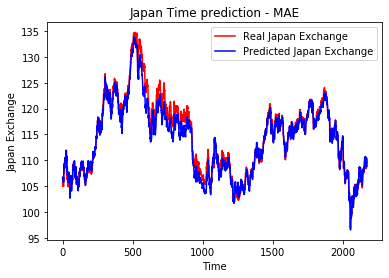

In [48]:
plt.plot(test_set[timesteps:len(y_test)].astype(float), color = 'red', label = 'Real Japan Exchange')
plt.plot(y_test[0:len(y_test) - timesteps].astype(float), color = 'blue', label = 'Predicted Japan Exchange')
plt.title('Japan Time prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Japan Exchange')
plt.legend()
plt.show()

In [49]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

1.4855332466774982


In [50]:
#MAE (mean absolut error)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print(mae)

1.1102797606635413
